# Chang (1998)

by Min Kim (min.kim@rutgers.edu), Jan 14, 2020

Reference:
 - [Chang (1998)](https://www.sciencedirect.com/science/article/pii/S002205319892395X)
 - Ljungqvist and Sargent (4th edition, Figure 25.6.1 and 25.6.2)
 - [Quantecon Python code](https://python-advanced.quantecon.org/chang_credible.html) by Sebastian Graves
 - [Yeltekin's Matlab code](http://sevinyeltekin.com/code/) for [Judd et al. (2003)](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.t01-1-00445)

In [27]:
using Parameters
using ForwardDiff, LinearAlgebra, QuantEcon
using Plots, LaTeXStrings
using Gurobi, JuMP # for lienar programming
using SharedArrays, Distributed # for parallel loop
using LazySets # for convexification

In [28]:
const GUROBI_ENV = Gurobi.Env() # to suppress Grubi license output

Academic license - for non-commercial use only


Gurobi.Env(Ptr{Nothing} @0x0000000090bf7010)

In [29]:
parameters = @with_kw (β = 0.8, m_min = 1e-9, mbar = 30, h_min = 0.9, h_max = 1/β)
functions = @with_kw (uc = c -> log(c), v = m -> 1/2000 * (mbar .* m .- 0.5 .* m.^2).^0.5,
   f = (h,m) -> 180 .- (0.4 .* m.*(h .- 1)).^2)

##NamedTuple_kw#395 (generic function with 2 methods)

In [30]:
# set 1: LS figure 25.6.2
@unpack β, mbar, m_min, h_min, h_max = parameters()
@unpack uc, v, f = functions() # utility and production functions

# set 2: LS figure 25.6.1
# @unpack β, mbar, h_min, h_max = parameters(β = 0.3, h_max = 2)
# @unpack uc, v, f = functions() # utility and production functions

# try
# @unpack β, mbar, h_min, h_max = parameters(β = 0.4, h_max = 2, m_min = 10, mbar = 30)

# set 3: Chang(1998)
# @unpack β, mbar, m_min, h_min, h_max = parameters(β = 0.9, mbar = 40, h_min = .25, h_max = 1.25)
# @unpack uc, v, f = functions(uc = c -> 10000*log(c),
    # v = m -> mbar .* m .- 0.5 .* m.^2, f = (h,m) -> 64 .- (0.2 .* m.*(h .- 1)).^2)

(uc = var"#49#55"(), v = var"#50#56"(), f = var"#51#57"())

In [31]:
m_max = mbar
# n_h = 5 # number of actions for h
n_h = 8 # number of actions for h
n_m = 35 # number of actions for m
# n_m = 5 # number of actions for m
n_a = n_h*n_m # number of combinations of actions
# n_g = 24 # number of subgradients
n_g = 48 # number of subgradients

x = (h,m) -> m.*(h .- 1) # tax from government budget constraint
u = (h,m) -> uc.(f.(h, m)) .+ v(m) #total utility after market clearing
D(f) = x -> ForwardDiff.derivative(f, x) # returns derivative of f
uc_p = D(uc)
v_p = D(v)
Euler = (h,m) -> m.*uc_p.(f.(h, m)).-v_p.(m) # left hand side of the Euler equation
Θ = (h,m) -> uc_p.(f.(h, m)) .* (m .*h) # promised utility

# grids
A_h = range(h_min,h_max, length = n_h)
A_m = range(m_min,m_max, length = n_m)
A = gridmake(A_h,A_m)

# Precompute utility and output vectors
Euler_vec = Euler(A[:,1],A[:,2])
f_vec = f(A[:,1],A[:,2])
u_vec = u(A[:,1],A[:,2])
Θ_vec = Θ(A[:,1],A[:,2])

# initial space as in Chang (1998)
# w_space = [maximum([u(h_min,0)/(1-β), u(h_max,0)/(1-β)]), u(1,m_max)/(1-β)]
# θ_space = [0, Θ(h_max,m_max)]

# initial space as in LS
p_vec = Θ_vec
w_vec = u_vec./(1-β)
w_space = [minimum(w_vec) maximum(w_vec)]
θ_space = [0 maximum((Θ_vec)./(1-β))]


1×2 Array{Float64,2}:
 0.0  1.09649

In [32]:
function initialize()

    # center and radius
    cen = [(w_space[2]+w_space[1])/2 (θ_space[2]+θ_space[1])/2]
    r1 = maximum([(w_space[2]- cen[1])^2, (cen[1] - w_space[1])^2])
    r2 = maximum([(θ_space[2]- cen[2])^2, (cen[2] - θ_space[1])^2])
    rad = sqrt(r1 + r2)
    degree = range(0, 2π, length=n_g)
    H = [cos.(degree) sin.(degree)]
    Z = cen .+ rad .* H
    C = Z .* H * [1,1] # hyperplane level
    return (C, H, Z)
end

initialize (generic function with 1 method)

In [33]:
# Initial hyperplane levels, subgradients, and verticies
c0, H, z0 = initialize()
# gr() # GR backend
# scatter(z0[:,1], z0[:,2], legend = false)

([26.452626668543168, 26.29470053708557, 25.677592360886464, 24.612314449969674, 23.117876713892418, 21.220947429458878, 18.955377344688866, 16.361595611417446, 13.485888326122687, 10.37957255343743  …  9.356348199225152, 12.524320422387305, 15.47884336018107, 18.167193480787613, 20.541397112616497, 22.5590865356118, 24.184256034220223, 25.387904420238122, 26.14855255970204, 26.452626668543168], [1.0 0.0; 0.9910774881547801 0.13328695537377883; … ; 0.99107748815478 -0.13328695537377913; 1.0 -2.4492935982947064e-16], [26.452626668543168 0.5482456140350878; 26.447602913905268 0.6232918534624999; … ; 26.447602913905268 0.47319937460767536; 26.452626668543168 0.5482456140350876])

In [34]:
c0_c, z0_c = c0_s, z0_s = copy(c0), copy(z0)
w_space_c, θ_space_c = w_space_s, θ_space_s = copy(w_space), copy(θ_space)

([25.7613507911023 26.01781726304005], [0.0 1.0964912280701755])

In [35]:
## Outer apporximaiton
# for competitive equilibria
function outer_competitive(c0_c,z0_c,w_space_c,θ_space_c)

   # c1_c, z1_c = SharedArray{Float64}(n_g), SharedArray{Float64}(n_g,2) # to be shared by workers
    c1_c, z1_c = copy(c0_c), copy(z0_c)

 @sync @distributed for i in 1:n_g
        c_action = -Inf*ones(n_a,1) # levels
        wp_action = zeros(n_a,2) # values
        for j in 1:n_a
            if !(f_vec[j]>0)
                break # nonpositive consumption
            end
#             m = Model(with_optimizer(Gurobi.Optimizer, GUROBI_ENV, Presolve=0, OutputFlag=0))
            m = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV), "Presolve" => 0, "OutputFlag" => 0))            
            @variable(m, w_space_c[1] <= w <=w_space_c[2])
            @variable(m, θ_space_c[1] <= θ <= θ_space_c[2])
            @objective(m, Max, dot(H[i,:],[w, θ]))
            # @objective(m, Max, dot(H[i,:],[u_vec[j,1]+β*w, Θ_vec[j,1]]))
            @constraint(m, constraint1, H*[w, θ] .<= c0_c)
            if A[j,2] == mbar
                @constraint(m, constraint2, Euler_vec[j] <= β*θ )
            else # m < mbar, then adding one equality constraint
                @constraint(m, constraint2, Euler_vec[j] == β*θ )
            end
            optimize!(m)
            if termination_status(m) == MOI.OPTIMAL
                c_action[j,1] = dot(H[i,:],[u_vec[j,1]+β*value(w), Θ_vec[j,1]]) # actual hyperplane level
                #c_action[j,1] = objective_value(m)
                wp_action[j,:] = [value(w) value(θ)]
            end
        end
        c1_c[i], idx = findmax(c_action) # the maximum
        z1_c[i,:] = [u_vec[idx]+β*wp_action[idx] Θ_vec[idx]] #taking into account other constraints
    end
    return c1_c, z1_c
end

outer_competitive (generic function with 1 method)

In [36]:
function worst_spe(w_space_s,θ_space_s)

    P_vec = SharedArray{Float64}(n_a)
#     P_vec = fill(missing,n_a)

 @sync @distributed for j in 1:n_a
    if !(f_vec[j]>0) 
        break # nonpositive consumption
    end
#     m = Model(with_optimizer(Gurobi.Optimizer, GUROBI_ENV, Presolve=0, OutputFlag=0))
    m = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV), "Presolve" => 0, "OutputFlag" => 0))        
    @variable(m, w_space_s[1] <= w <=w_space_s[2])
    @variable(m, θ_space_s[1] <= θ <= θ_space_s[2])
    @objective(m, Min, u_vec[j,1] + β * w)
    @constraint(m, constraint1, H*[w, θ] .<= c0_s)
    if A[j,2] == mbar
    # m = mbar, then adding one more inequality constraint
        @constraint(m, constraint2, Euler_vec[j] <= β*θ)
    else # m < mbar, then adding one equality constraint
       @constraint(m, constraint2, Euler_vec[j] == β*θ)
    end
    optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
       P_vec[j] = objective_value(m)
    end
    end
# Max over h and min over other variables
BR = maximum(minimum(reshape(P_vec,n_h, n_m), dims=1))
    return BR
end

worst_spe (generic function with 1 method)

In [37]:
# for sustainable plans
function outer_sustainable(BR,c0_s,z0_s,w_space_s,θ_space_s)

    # c1_s, z1_s = SharedArray{Float64}(n_g), SharedArray{Float64}(n_g,2) # to be shared by workers
    c1_s, z1_s = copy(c0_s), copy(z0_s)

 @sync @distributed for i in 1:n_g
        c_action = -Inf*ones(n_a,1) # levels
        wp_action = zeros(n_a,2) # values
        for j in 1:n_a
            if !(f_vec[j]>0)
                break # nonpositive consumption
            end
#             m = Model(with_optimizer(Gurobi.Optimizer, GUROBI_ENV, Presolve=0, OutputFlag=0))
            m = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV), "Presolve" => 0, "OutputFlag" => 0))
            @variable(m, w_space_s[1] <= w <=w_space_s[2])
            @variable(m, θ_space_s[1] <= θ <= θ_space_s[2])
            #@objective(m, Min, u_vec[j,1] + β * w)
            @objective(m, Max, dot(H[i,:],[w, θ]))
            @constraint(m, constraint1, H*[w, θ] .<= c0_s)
            @constraint(m, constraint3, BR <= u_vec[j]+β*w)
            if A[j,2] == mbar
                @constraint(m, constraint2, Euler_vec[j] <= β*θ )
            else # m < mbar, then adding one equality constraint
                @constraint(m, constraint2, Euler_vec[j] == β*θ )
            end
            optimize!(m)
            if termination_status(m) == MOI.OPTIMAL
                c_action[j,1] = dot(H[i,:],[u_vec[j,1]+β*value(w), Θ_vec[j,1]]) # actual hyperplane level
                wp_action[j,:] = [value(w) value(θ)]
            end
        end
        c1_s[i], idx = findmax(c_action) # the maximum
        z1_s[i,:] = [u_vec[idx]+β*wp_action[idx] Θ_vec[idx]] #taking into account other constraints
    end
    return c1_s, z1_s
end

outer_sustainable (generic function with 1 method)

In [38]:
function ChangModel(c0_c,z0_c,c0_s,z0_s,w_space_c,θ_space_c,w_space_s,θ_space_s;
    # tol = 1e-3,
    tol = 1e-5,
    # tol = 1e-9,
    max_iter = 250,
    diff = tol + 1,
    diff_z = tol + 1)

     c1_c, z1_c = copy(c0_c), copy(z0_c)

     c1_s, z1_s = copy(c0_s), copy(z0_s)
 for iters in 1:max_iter
        c1_c, z1_c = outer_competitive(c0_c,z0_c,w_space_c,θ_space_c)

        BR = worst_spe(w_space_s,θ_space_s)
        c1_s, z1_s =  outer_sustainable(BR,c0_s,z0_s,w_space_s,θ_space_s)

        # difference in hyplerplane levels
        diff = minimum([maximum(abs.(c0_c - c1_c)), maximum(abs.(c0_s - c1_s))]) # sooner
        # diff = maximum([maximum(abs.(c0_c - c1_c)), maximum(abs.(c0_s - c1_s))]) # later
        # difference in extreme points
        diff_z = maximum([maximum(abs.(z1_c-z0_c)./(1 .+ abs.(z0_c))), maximum(abs.(z1_s-z0_s)./(1 .+ abs.(z0_s)))])
        # diff_z = minimum([maximum(abs.(z1_c-z0_c)./(1 .+ abs.(z0_c))), maximum(abs.(z1_s-z0_s)./(1 .+ abs.(z0_s)))])

        # print results
        if mod(iters,1) == 0
            println("iteration #$iters: difference is $diff, $diff_z")
        end

        # break
        if  diff < tol || diff_z < tol
            break
        end

        # update
        c0_c, z0_c = copy(c1_c), copy(z1_c)
        c0_s, z0_s = copy(c1_s), copy(z1_s)
        w_space_c = [minimum(z1_c[:,1]), maximum(z1_c[:,1])]
        θ_space_c = [minimum(z1_c[:,2]), maximum(z1_c[:,2])]
        w_space_s = [minimum(z1_s[:,1]), maximum(z1_s[:,1])]
        θ_space_s = [minimum(z1_s[:,2]), maximum(z1_s[:,2])]
end
    return  c1_c, z1_c, c1_s, z1_s
end


ChangModel (generic function with 1 method)

In [39]:
# Results
@time c1_c, z1_c, c1_s, z1_s = ChangModel(c0_c,z0_c,c0_s,z0_s,w_space_c,θ_space_c,w_space_s,θ_space_s)

iteration #1: difference is 0.8875214031201635, 0.42240011359321034
iteration #2: difference is 0.032800710280348255, 0.21394257951742784
iteration #3: difference is 0.02481438979947015, 0.025974025973133953
iteration #4: difference is 0.018337328847962908, 0.2086335368312195
iteration #5: difference is 0.012960231968328628, 0.0833712515121931
iteration #6: difference is 0.010083575992304361, 0.1156226779547478
iteration #7: difference is 0.007022416525877873, 0.04378387441913222
iteration #8: difference is 0.005324000273006391, 0.02947735788276953
iteration #9: difference is 0.004259200218410086, 0.012316543242811333
iteration #10: difference is 0.0034230415209854925, 0.013014129135273236
iteration #11: difference is 0.002848704186252604, 0.012858146226508072
iteration #12: difference is 0.002278963349002794, 0.006529787797708546
iteration #13: difference is 0.0018231706792057878, 0.005481485072661978
iteration #14: difference is 0.0014824344337327489, 0.005497953657707505
iteration #

([25.99322399897939, 25.765641368263367, 25.07940813404647, 23.947190907987306, 22.389149479160512, 20.43395924547124, 18.11708834284791, 15.481067577196495, 12.576622807535685, 9.463617219477053  …  9.332233840087929, 12.481859747195758, 15.408746571414113, 18.060663948025617, 20.390288348619535, 22.356145402825472, 23.923650804164403, 25.064272524359517, 25.758198687565557, 25.99322399897939], [25.99322399897939 0.02941176471045752; 25.992759414282887 0.036032466424797176; … ; 25.992469184968932 0.01764901304391933; 25.99322399897939 0.02941176471045752], [25.99267644953289, 25.764635751165663, 25.0778740533394, 23.944617047247643, 22.384627523873668, 20.425338766025902, 18.10155935401314, 15.454757186494119, 12.532164510852109, 9.385935062621453  …  9.332196389713674, 12.481809670464113, 15.40868476194554, 18.060591508811548, 20.390206572339462, 22.355985877475025, 23.92348010829476, 25.064059269824206, 25.757840271395445, 25.99267644953289], [25.99267644953289 0.02450980392630719; 

In [40]:
v_c, v_s = fill(Float64[], n_g), fill(Float64[], n_g)
for i in 1:n_g
    v_c[i] = z1_c[i,:]
    v_s[i] = z1_s[i,:]
end
hull_c = convex_hull(v_c)
hull_s = convex_hull(v_s)

10-element Array{Array{Float64,1},1}:
 [25.98672764970181, 0.008823773673181524]
 [25.9883933240489, 0.008823773673181524]
 [25.99103925748768, 0.013236118517131395]
 [25.992107542035463, 0.01764901304391933]
 [25.99267644953289, 0.02450980392630719]
 [25.99223850751157, 0.032361003438417774]
 [25.990919547828792, 0.03949091493037129]
 [25.988395294156188, 0.04714234214760601]
 [25.98737323452967, 0.04915567893202606]
 [25.98672764970181, 0.04915567893202606]

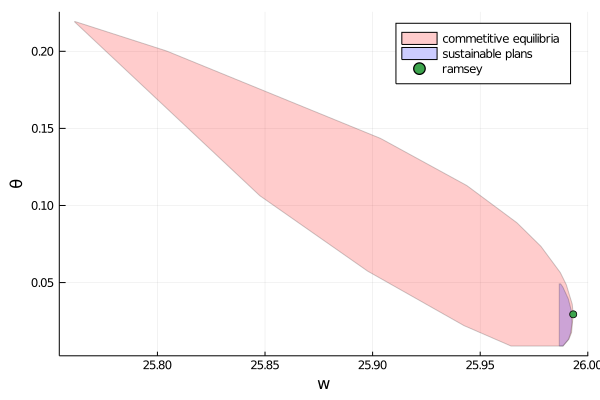

In [41]:
p = plot(VPolygon(hull_c), alpha=0.2, fillcolor = :red, xlabel = "w", ylabel = "θ", label = "commetitive equilibria")
plot!(p, VPolygon(hull_s), alpha=0.2, fillcolor = :blue, label = "sustainable plans")
scatter!([v_c[1][1]],[v_c[1][2]], label = "ramsey")
# savefig("b$β"*"g"*"$n_g"*".png")
# savefig("b$β"*"g"*"$n_g"*"_2"*".png")